# Analysis Processed Slocum Glider-AD2CP Data: RU29 2021 Mission 2

In [189]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
#sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [190]:
ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.0,18.172288,-64.968623,2021-09-08T19:43:16.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
1,NaN,18.172288,-64.968623,2021-09-08T19:43:22.01Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
2,0.0,18.172288,-64.968623,2021-09-08T19:43:23.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
3,NaN,18.172288,-64.968623,2021-09-08T19:44:26.30Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
4,NaN,18.172270,-64.968681,2021-09-08T19:44:52.37Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1453164,NaN,NaN,NaN,2021-10-07T19:57:17.47Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453165,NaN,NaN,NaN,2021-10-07T19:57:23.31Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453166,NaN,NaN,NaN,2021-10-07T19:57:30.35Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453167,NaN,NaN,NaN,2021-10-07T19:57:34.80Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [191]:
dz=10

path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)

files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df


,Unnamed: 0,inversion_u,inversion_v,inversion_depth,start_lon,start_lat,end_lon,end_lat,start_tm,end_tm,obs_per_bin
0,0,-0.140968,0.036835,5.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,662.0
1,1,-0.141933,0.050153,15.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,7561.0
2,2,-0.146303,0.052243,25.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,10131.0
3,3,-0.153214,0.064736,35.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,9796.0
4,4,-0.159064,0.078742,45.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,8707.0
...,...,...,...,...,...,...,...,...,...,...,...
76,76,-0.009726,0.065447,765.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,5288.0
77,77,-0.003630,0.071329,775.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,4845.0
78,78,0.000710,0.072544,785.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,4409.0
79,79,-0.000416,0.072528,795.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,3796.0


In [192]:
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 2 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:     (depth: 102, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 995.0 1.005e+03 1.015e+03
Data variables:
    u_grid      (depth, time) float64 -0.141 0.007458 -0.04472 ... nan nan nan
    v_grid      (depth, time) float64 0.03683 0.05545 0.03476 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.14 ... 18.15 18.16 18.16
    longitude   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_lat   (time) float64 18.17 18.17 18.17 18.15 ... 18.15 18.16 18.16
    start_lon   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16
    end_lon     (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_time  (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-...
    end_time    (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
Attributes:
    description:  Master/combined RU29 2021 Mission 2 AD2CP least-squares inv...

/tmp/ipykernel_83379/304361943.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.time,ds.depth,ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)


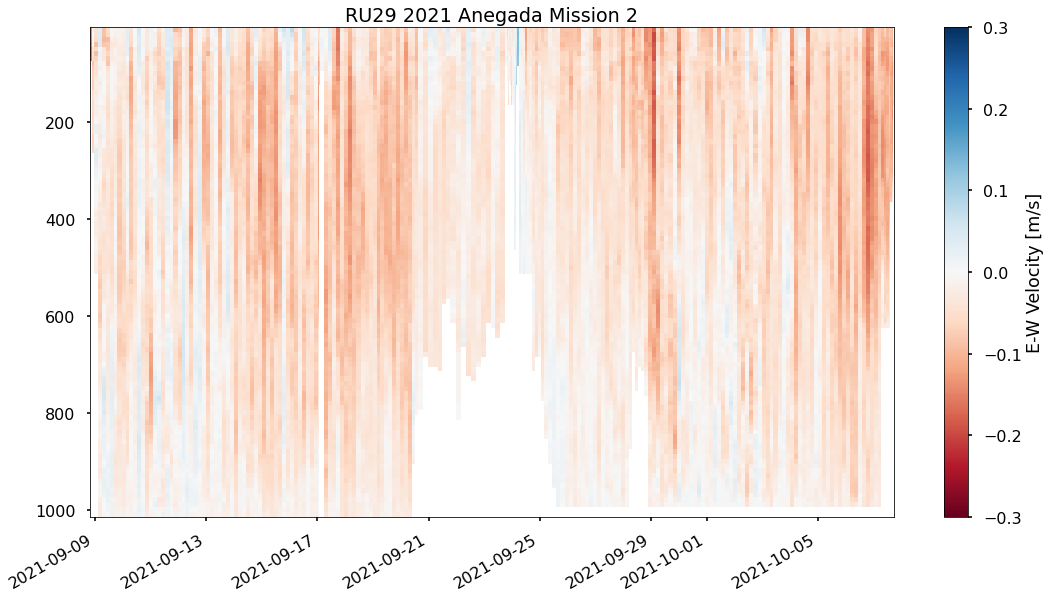

In [193]:
plt.figure(figsize=(18,10))
plt.pcolormesh(ds.time,ds.depth,ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')
plt.gcf().autofmt_xdate()

/tmp/ipykernel_83379/3646313232.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.time,ds.depth,ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)


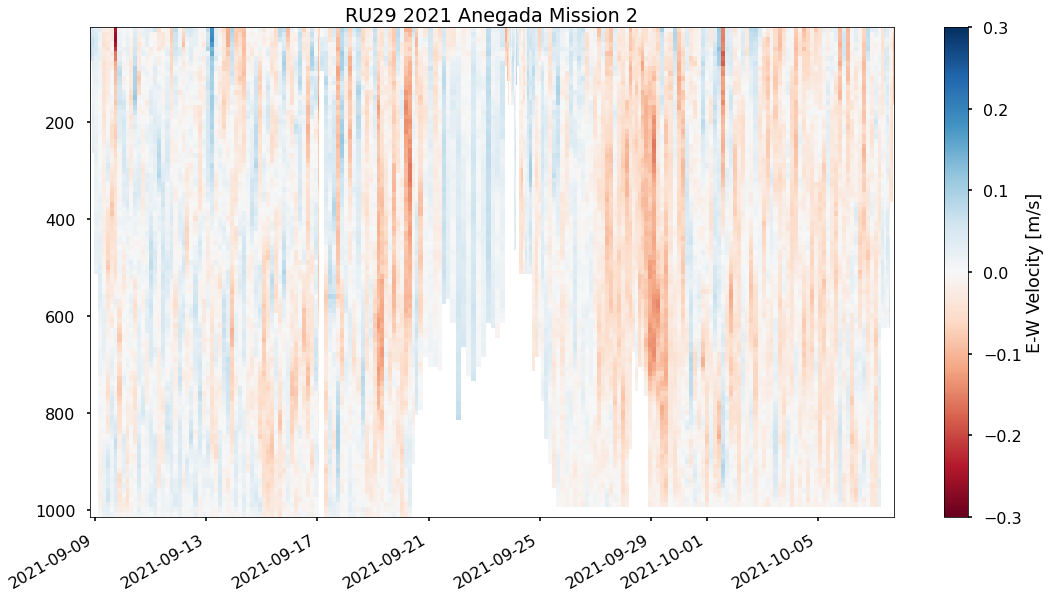

In [194]:
plt.figure(figsize=(18,10))
plt.pcolormesh(ds.time,ds.depth,ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')
plt.gcf().autofmt_xdate()

## Anegada Subset

In [195]:
subset_ds = ds.sel(time=slice("2021-09-14 00:00:00","2021-09-18 11:00:00"))

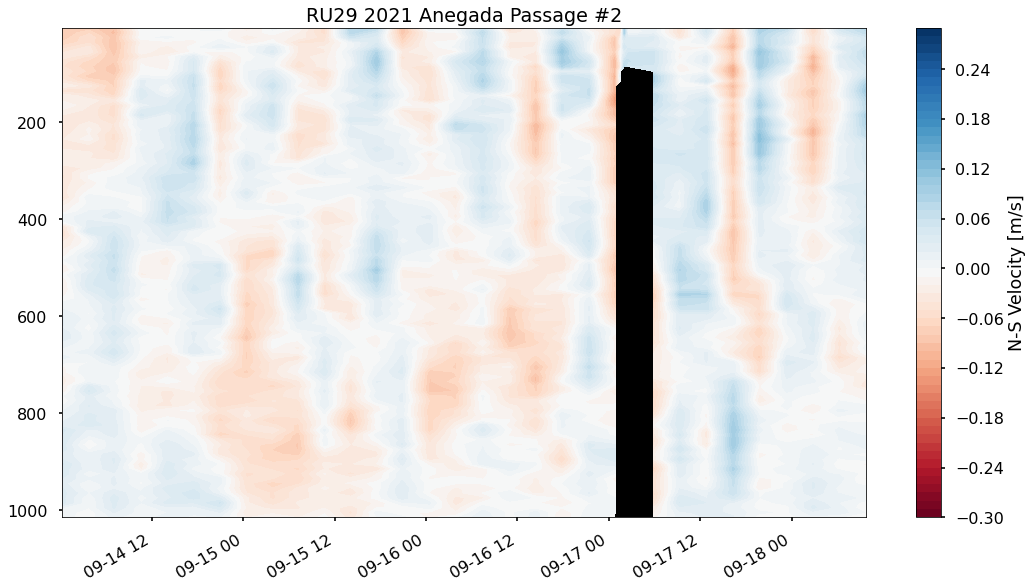

In [196]:
plt.figure(figsize=(18,10))
plt.gca().set_facecolor("black")

plt.contourf(subset_ds.time,subset_ds.depth,subset_ds.v_grid,cmap='RdBu',levels=np.arange(-0.3,0.3,0.01))
plt.gca().invert_yaxis()
plt.colorbar(label='N-S Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #2')
plt.gcf().autofmt_xdate()

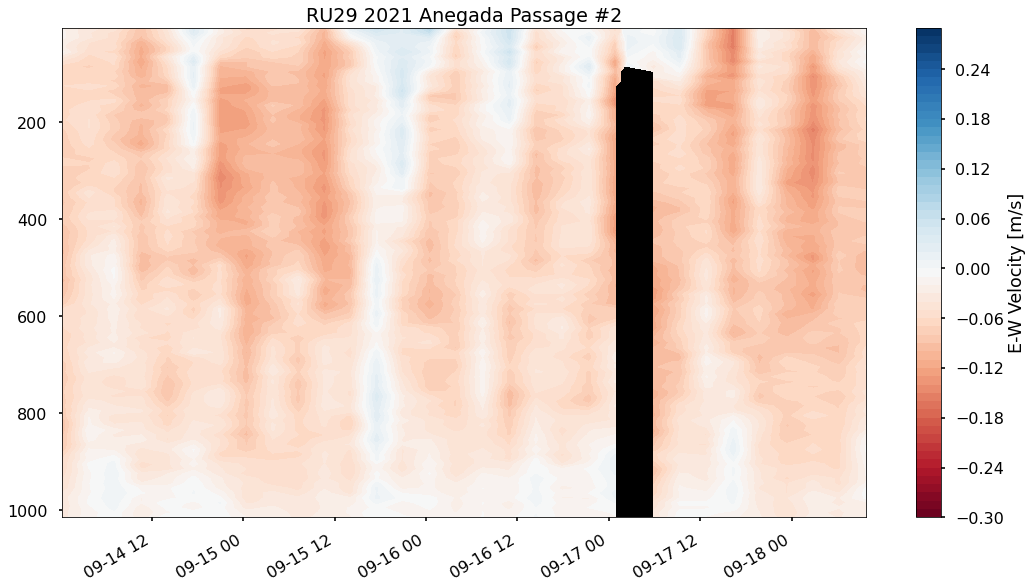

In [197]:
plt.figure(figsize=(18,10))
plt.contourf(subset_ds.time,subset_ds.depth,subset_ds.u_grid,cmap='RdBu',levels=np.arange(-0.3,0.3,0.01))
plt.gca().set_facecolor("black")

plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #2')
plt.gcf().autofmt_xdate()

## What do "transport" look like through this section?

### Need to do calculation with distance PER segment!

In [198]:
segment_distances = np.empty(len(subset_ds.time))
segment_distances[:] = np.NaN

for x in np.arange(0,len(subset_ds.time)):
    segment_distances[x] = dist_from_lat_lon(subset_ds.start_lat[x],subset_ds.start_lon[x],subset_ds.end_lat[x],subset_ds.end_lon[x])
    

In [199]:
transport_u = np.empty(len(segment_distances))
transport_u[:] = np.NaN
transport_v = np.empty(len(segment_distances))
transport_v[:] = np.NaN

for x in np.arange(0,len(segment_distances)):
    transport_u[x] = (np.nansum(subset_ds.u_grid[:,x].values)*dz*segment_distances[x])/(10**6)
    transport_v[x] = (np.nansum(subset_ds.v_grid[:,x].values)*dz*segment_distances[x])/(10**6) 

In [200]:
np.nansum(transport_u)

-5.701500640962258

In [201]:
np.nansum(transport_v)

-0.5862965169987635

##  Rotate velocities by the orientation of the mouth of the Anegada Passage

<br><br>
Cross Passage Velocity = $U*cos(18) - V*sin(18)$ <br><br>
Along Passage Velocity = $U*sin(18) + V*cos(18)$<br><br>

In [202]:
cross_vel = subset_ds.u_grid*np.cos(np.deg2rad(18)) - subset_ds.v_grid*np.sin(np.deg2rad(18))

along_vel = subset_ds.u_grid*np.sin(np.deg2rad(18)) + subset_ds.v_grid*np.cos(np.deg2rad(18))


In [203]:
transport_along = np.empty(len(segment_distances))
transport_along[:] = np.NaN
transport_cross = np.empty(len(segment_distances))
transport_cross[:] = np.NaN

for x in np.arange(0,len(segment_distances)):
    transport_along[x] = (np.nansum(along_vel[:,x].values)*dz*segment_distances[x])/(10**6)
    transport_cross[x] = (np.nansum(cross_vel[:,x].values)*dz*segment_distances[x])/(10**6) 


In [204]:
np.nansum(transport_cross)

-5.241273749752692

In [205]:
np.nansum(transport_along)

-2.3194617144698193

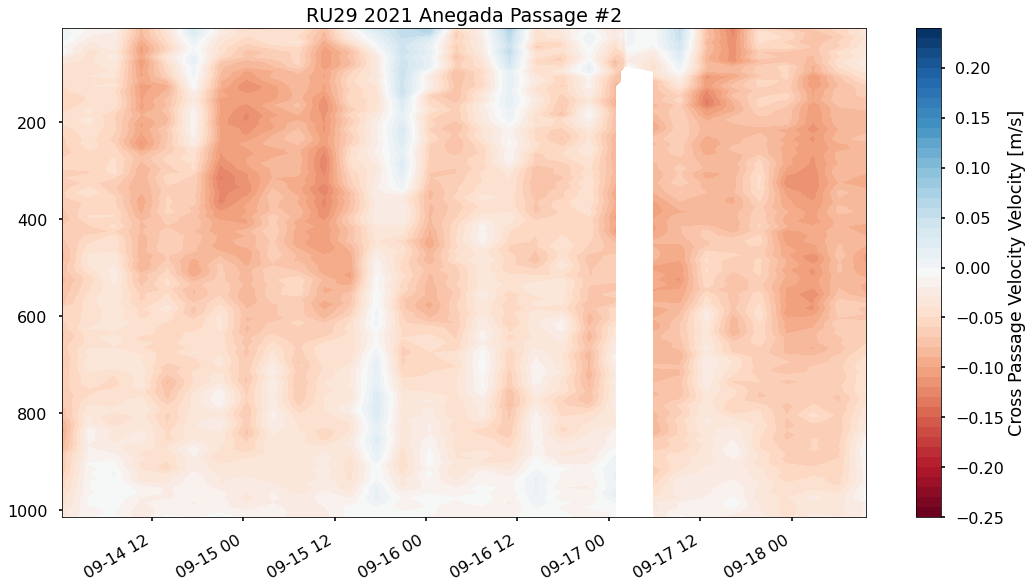

In [206]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
contour = ax.contourf(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
ax.patch.set_alpha(0.1)
ax.invert_yaxis()
fig.colorbar(contour,label='Cross Passage Velocity Velocity [m/s]')
ax.set_title('RU29 2021 Anegada Passage #2')
fig.autofmt_xdate()

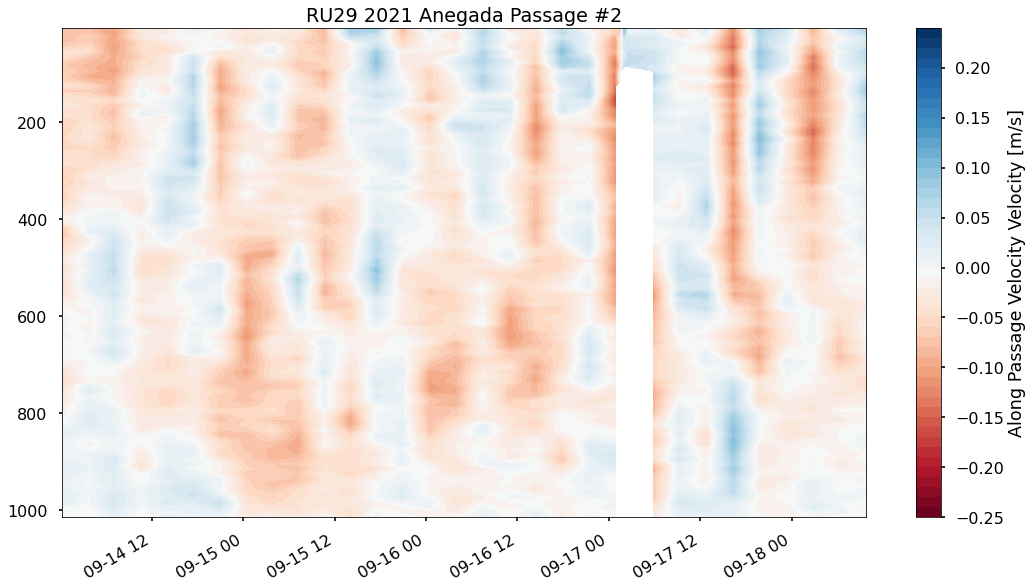

In [207]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
contour = ax.contourf(subset_ds.time,subset_ds.depth,along_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
ax.patch.set_alpha(0.2)
ax.invert_yaxis()
fig.colorbar(contour,label='Along Passage Velocity Velocity [m/s]')
ax.set_title('RU29 2021 Anegada Passage #2')
fig.autofmt_xdate()

## Look at how much of the transport is above/below 200 meters for comparison with Johns et al. 1999

In [208]:
depth_ind = subset_ds.depth.values < 200

test = cross_vel[depth_ind,:].values

transport_gridu_200 = np.empty(len(segment_distances))
transport_gridu_200[:] = np.NaN

for x in np.arange(0,len(segment_distances)):
    transport_gridu_200[x] = (np.nansum(test[:,x])*dz*segment_distances[x])/(10**6)


In [209]:
np.nansum(transport_gridu_200)/np.nansum(transport_cross)

0.1816729344756795

## Interpolate glider temperature, salinity, and density data onto same grid as transport data

In [210]:
sci_ds_id = 'ru29-20210908T1943-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'potential_temperature', 'salinity','density']
sci_gdf = get_erddap_dataset(sci_ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
variables = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'salinity','density']
sci_gdf.columns = variables



## Edit time formatting for subsetting
glider_times = pd.to_datetime(sci_gdf.time.values).tz_localize(None)
sci_gdf.time = glider_times

sci_gdf

,depth,latitude,longitude,time,temperature,salinity,density
0,-0.04970,18.172249,-64.968765,2021-09-08 19:45:29.540,30.167812,34.781155,1021.50460
1,NaN,18.172250,-64.968767,2021-09-08 19:45:30.290,NaN,NaN,NaN
2,-0.01988,18.172250,-64.968769,2021-09-08 19:45:31.550,30.169704,34.782074,1021.50470
3,0.00994,18.172250,-64.968772,2021-09-08 19:45:33.570,30.162397,34.783863,1021.50867
4,0.00994,18.172250,-64.968775,2021-09-08 19:45:35.580,30.163597,34.782463,1021.50726
...,...,...,...,...,...,...,...
1401589,0.01988,18.164149,-64.814803,2021-10-07 17:22:08.740,29.520494,34.403038,1021.44170
1401590,0.08946,18.164149,-64.814801,2021-10-07 17:22:10.750,29.522078,34.403030,1021.44147
1401591,NaN,18.164148,-64.814800,2021-10-07 17:22:11.870,NaN,NaN,NaN
1401592,0.06958,18.164149,-64.814802,2021-10-07 17:22:12.770,29.525682,34.402367,1021.43970


In [211]:
## Pull out depth to interpolate onto
griddepth = ds.depth.values

## Pre-allocate
gridtemp = np.empty((len(griddepth),len(subset_ds.time)))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(griddepth),len(subset_ds.time)))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(griddepth),len(subset_ds.time)))
griddensity[:] = np.NaN


for x in np.arange(0,len(subset_ds.time)):
    sci_gdf2 = sci_gdf.loc[(sci_gdf.time.values >= subset_ds.start_time.values[x]) & (sci_gdf.time.values <= subset_ds.end_time.values[x])]

    gridtemp[:,x]     = interp.griddata(sci_gdf2.depth.values,sci_gdf2.temperature.values,griddepth)
    gridsalinity[:,x] = interp.griddata(sci_gdf2.depth.values,sci_gdf2.salinity.values,griddepth)
    griddensity[:,x]  = interp.griddata(sci_gdf2.depth.values,sci_gdf2.density.values,griddepth)


In [212]:
cross_vel.shape

(102, 34)

In [213]:
gridtemp.shape

(102, 34)

### Save t/s/den and velocity data together now

In [214]:
# grid_ds = xr.Dataset(
#     data_vars=dict(
#         cross_vel =(["depth", "dist"], cross_vel.values),
#         along_vel =(["depth", "dist"], along_vel.values),
#         temp = (["depth", "dist"], gridtemp),
#         sal = (["depth", "dist"], gridsalinity),
#         density = (["depth", "dist"], griddensity)
#     ),
#     coords=dict(
#         depth=griddepth,
#         dist=segment_distances
#     ),
#     attrs=dict(description="Processed RU29 AD2CP and CTD data from the 2021 Deployment #2. Gridded/interpolated onto transect latitude grid"),
# )

# grid_ds

In [215]:
# fname = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Gridded/RU29_2021_Mission_2_Gridded_ADCP_CTD.nc"
# grid_ds.to_netcdf(fname)

## Transport per temperature range

In [216]:
transport_u_1 = np.empty(len(segment_distances))
transport_u_1[:] = np.NaN
transport_v_1 = np.empty(len(segment_distances))
transport_v_1[:] = np.NaN

transport_u_2 = np.empty(len(segment_distances))
transport_u_2[:] = np.NaN
transport_v_2 = np.empty(len(segment_distances))
transport_v_2[:] = np.NaN

transport_u_3 = np.empty(len(segment_distances))
transport_u_3[:] = np.NaN
transport_v_3 = np.empty(len(segment_distances))
transport_v_3[:] = np.NaN

transport_u_4 = np.empty(len(segment_distances))
transport_u_4[:] = np.NaN
transport_v_4 = np.empty(len(segment_distances))
transport_v_4[:] = np.NaN

transport_u_5 = np.empty(len(segment_distances))
transport_u_5[:] = np.NaN
transport_v_5 = np.empty(len(segment_distances))
transport_v_5[:] = np.NaN


for x in np.arange(0,len(segment_distances)):
    ## Find where temp fits criteria and only sum up transport there
    ind1 = np.where(gridtemp[:,x] < 7)[0]
    ## Only sum up transport for these indexes
    transport_u_1[x] = (np.nansum(cross_vel[ind1,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_1[x] = (np.nansum(along_vel[ind1,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind2 = np.where((gridtemp[:,x] > 7) & (gridtemp[:,x] < 12))[0]
    ## Only sum up transport for these indexes
    transport_u_2[x] = (np.nansum(cross_vel[ind2,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_2[x] = (np.nansum(along_vel[ind2,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind3 = np.where((gridtemp[:,x] > 12) & (gridtemp[:,x] < 17))[0]
    ## Only sum up transport for these indexes
    transport_u_3[x] = (np.nansum(cross_vel[ind3,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_3[x] = (np.nansum(along_vel[ind3,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind4 = np.where((gridtemp[:,x] > 17) & (gridtemp[:,x] < 24))[0]
    ## Only sum up transport for these indexes
    transport_u_4[x] = (np.nansum(cross_vel[ind4,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_4[x] = (np.nansum(along_vel[ind4,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind5 = np.where(gridtemp[:,x] > 24)[0]
    ## Only sum up transport for these indexes
    transport_u_5[x] = (np.nansum(cross_vel[ind5,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_5[x] = (np.nansum(along_vel[ind5,x].values)*dz*segment_distances[x])/(10**6) 
    


In [217]:
range1 = np.nansum(transport_u_1)
print('Transport <7 degrees C',range1,'Sv')

range2 = np.nansum(transport_u_2)
print('Transport between 7-12 degrees C',range2,'Sv')

range3 = np.nansum(transport_u_3)
print('Transport between 12-17 degrees C',range3,'Sv')

range4 = np.nansum(transport_u_4)
print('Transport between 17-24 degrees C',range4,'Sv')

range5 = np.nansum(transport_u_5)
print('Transport >24 degrees C',range5,'Sv')


Transport <7 degrees C -0.7791997908076259 Sv
Transport between 7-12 degrees C -1.4281667664547264 Sv
Transport between 12-17 degrees C -1.498508627300663 Sv
Transport between 17-24 degrees C -0.9163457965998257 Sv
Transport >24 degrees C -0.586786146496661 Sv


In [218]:
np.nansum(transport_u_1)+ np.nansum(transport_u_2)+np.nansum(transport_u_3)+np.nansum(transport_u_4)+np.nansum(transport_u_5)


-5.209007127659502

# Save output

In [219]:
# temp_df = pd.DataFrame(np.column_stack([range1, range2, range3, range4, range5]), columns=['range1','range2','range3','range4','range5'])
# temp_df

# temp_df.to_csv('/home/jg1200/Data/GliderData/RU29/transport_per_temperature_class_sep_2021.csv')



## Transport of 18 C water

In [220]:
transport_u_18 = np.empty(len(segment_distances))
transport_u_18[:] = np.NaN
transport_v_18 = np.empty(len(segment_distances))
transport_v_18[:] = np.NaN

min_temp = 17
max_temp = 19
min_sal  = 36.25
max_sal  = 36.75

for x in np.arange(0,len(segment_distances)):
    ## Find where temp fits criteria and only sum up transport there
    ind1 = np.where((gridtemp[:,x] >= min_temp) & (gridtemp[:,x] <= max_temp) & (gridsalinity[:,x] >= min_sal) & (gridsalinity[:,x] <= max_sal))[0]
    ## Only sum up transport for these indexes
    transport_u_18[x] = (np.nansum(cross_vel[ind1,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_18[x] = (np.nansum(along_vel[ind1,x].values)*dz*segment_distances[x])/(10**6) 


In [221]:
np.nansum(transport_u_18)

-0.3616291890963957

In [222]:
np.nansum(transport_v_18)

-0.1448646921485685

## Plot 2021 Missions 1 and 2 together

In [223]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
#path = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2021_Mission_1_Processed_Velocity_Profiles/"
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))


inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_a = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 1 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_a = ds_a.sortby(ds_a.time)
ds_a


<xarray.Dataset>
Dimensions:     (depth: 98, time: 113)
Coordinates:
  * time        (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 -0.1183 -0.07372 -0.05783 ... nan nan nan
    v_grid      (depth, time) float64 -0.0172 0.04695 0.006812 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    longitude   (time) float64 -64.83 -64.83 -64.81 ... -63.81 -63.82 -63.83
    start_lat   (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    start_lon   (time) float64 -64.83 -64.83 -64.82 ... -63.8 -63.82 -63.83
    end_lat     (time) float64 18.17 18.16 18.15 18.14 ... 18.15 18.15 18.14
    end_lon     (time) float64 -64.83 -64.82 -64.8 ... -63.82 -63.83 -63.83
    start_time  (time) datetime64[ns] 2021-06-30T13:43:52 ... 2021-07-14T10:2...
    end_time    (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
Attributes:
    description:  Master/combined RU29 2021 Mission 1 AD2CP least-squares inv...

In [224]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))

inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_b = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 2 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_b = ds_b.sortby(ds_b.time)
ds_b


<xarray.Dataset>
Dimensions:     (depth: 102, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 995.0 1.005e+03 1.015e+03
Data variables:
    u_grid      (depth, time) float64 -0.141 0.007458 -0.04472 ... nan nan nan
    v_grid      (depth, time) float64 0.03683 0.05545 0.03476 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.14 ... 18.15 18.16 18.16
    longitude   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_lat   (time) float64 18.17 18.17 18.17 18.15 ... 18.15 18.16 18.16
    start_lon   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16
    end_lon     (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_time  (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-...
    end_time    (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
Attributes:
    description:  Master/combined RU29 2021 Mission 2 AD2CP least-squares inv...

## Subset to just the transects

In [225]:
subset_ds_a = ds_a.sel(time=slice("2021-07-04 15:00:00","2021-07-09 23:59:00"))
subset_ds_b = ds_b.sel(time=slice("2021-09-14 00:00:00","2021-09-18 11:00:00"))

In [226]:
subset_ds_a

<xarray.Dataset>
Dimensions:     (depth: 98, time: 39)
Coordinates:
  * time        (time) datetime64[ns] 2021-07-04T17:09:48 ... 2021-07-09T22:0...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 0.04838 0.03983 0.001043 ... nan nan nan
    v_grid      (depth, time) float64 0.0412 0.00962 0.02406 ... nan nan nan
    latitude    (time) float64 18.42 18.43 18.43 18.43 ... 18.34 18.35 18.35
    longitude   (time) float64 -64.31 -64.28 -64.25 ... -63.41 -63.39 -63.37
    start_lat   (time) float64 18.41 18.43 18.43 18.43 ... 18.34 18.34 18.35
    start_lon   (time) float64 -64.32 -64.3 -64.26 ... -63.42 -63.4 -63.38
    end_lat     (time) float64 18.43 18.43 18.43 18.43 ... 18.34 18.35 18.35
    end_lon     (time) float64 -64.3 -64.26 -64.23 ... -63.4 -63.38 -63.36
    start_time  (time) datetime64[ns] 2021-07-04T14:28:32 ... 2021-07-09T19:5...
    end_time    (time) datetime64[ns] 2021-07-04T17:09:48 ... 2021-07-09T22:0...
Attributes:
    description:  Master/combined RU29 2021 Mission 1 AD2CP least-squares inv...

## Rotate both!

<br><br>
Cross Passage Velocity = $U*cos(18) - V*sin(18)$ <br><br>
Along Passage Velocity = $U*sin(18) + V*cos(18)$<br><br>

In [227]:
cross_vel_a = subset_ds_a.u_grid*np.cos(np.deg2rad(18)) - subset_ds_a.v_grid*np.sin(np.deg2rad(18))
along_vel_a = subset_ds_a.u_grid*np.sin(np.deg2rad(18)) + subset_ds_a.v_grid*np.cos(np.deg2rad(18))

cross_vel_b = subset_ds_b.u_grid*np.cos(np.deg2rad(18)) - subset_ds_b.v_grid*np.sin(np.deg2rad(18))
along_vel_b = subset_ds_b.u_grid*np.sin(np.deg2rad(18)) + subset_ds_b.v_grid*np.cos(np.deg2rad(18))



## Distance calculation for b for plotting

In [228]:
segment_distances_a = np.empty(len(subset_ds_a.time))
segment_distances_a[:] = np.NaN
segment_distances_b = np.empty(len(subset_ds_b.time))
segment_distances_b[:] = np.NaN

for x in np.arange(0,len(subset_ds_a.time)):
    segment_distances_a[x] = dist_from_lat_lon(subset_ds_a.start_lat[x],subset_ds_a.start_lon[x],subset_ds_a.end_lat[x],subset_ds_a.end_lon[x])
cum_dist_a = np.cumsum(segment_distances_a)/1000


for x in np.arange(0,len(subset_ds_b.time)):
    segment_distances_b[x] = dist_from_lat_lon(subset_ds_b.start_lat[x],subset_ds_b.start_lon[x],subset_ds_b.end_lat[x],subset_ds_b.end_lon[x])
cum_dist_b = np.cumsum(segment_distances_b)/1000



## Plot it up

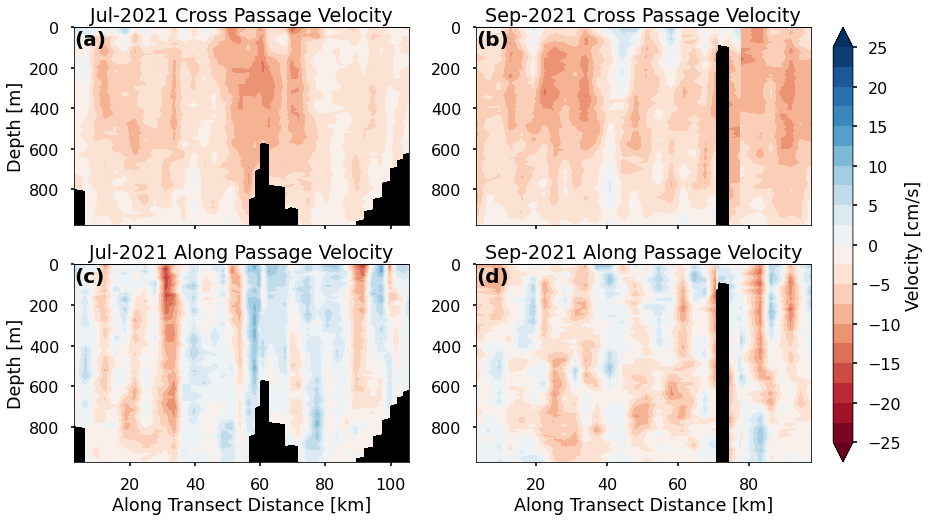

In [229]:
font_size = 20

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(16,8))

axlist = [ax1,ax2,ax3,ax4]

color_levels = np.arange(-25,25+0.1,2.5)

first = ax1.contourf(cum_dist_a,subset_ds_a.depth,cross_vel_a*100,cmap='RdBu',levels=color_levels,extend='both')
ax1.patch.set_facecolor('black')
ax1.set_title('Jul-2021 Cross Passage Velocity')
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(975,0)
ax1.text(0,0.91,'(a)', transform=ax1.transAxes, size=font_size, weight='bold')

second = ax2.contourf(cum_dist_b,subset_ds_b.depth,cross_vel_b*100,cmap='RdBu',levels=color_levels,extend='both')
ax2.patch.set_facecolor('black')
ax2.set_title('Sep-2021 Cross Passage Velocity')
ax2.xaxis.set_ticklabels([])
ax2.set_ylim(975,0)
ax2.text(0,0.91,'(b)', transform=ax2.transAxes, size=font_size, weight='bold')

third = ax3.contourf(cum_dist_a,subset_ds_a.depth,along_vel_a*100,cmap='RdBu',levels=color_levels,extend='both')
ax3.patch.set_facecolor('black')
ax3.set_title('Jul-2021 Along Passage Velocity')
ax3.set_xlabel('Along Transect Distance [km]')
ax3.set_ylabel('Depth [m]')
ax3.set_ylim(975,0)
ax3.text(0,0.91,'(c)', transform=ax3.transAxes, size=font_size, weight='bold')

fourth = ax4.contourf(cum_dist_b,subset_ds_b.depth,along_vel_b*100,cmap='RdBu',levels=color_levels,extend='both')
ax4.patch.set_facecolor('black')
ax4.set_title('Sep-2021 Along Passage Velocity')
ax4.set_xlabel('Along Transect Distance [km]')
ax4.set_ylim(975,0)
ax4.text(0,0.91,'(d)', transform=ax4.transAxes, size=font_size, weight='bold')


cbar = fig.colorbar(first, ax=axlist,label='Velocity [cm/s]',pad=0.025)
cbar.get_ticks()
cbar.set_ticks([-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])

plt.savefig('/home/jg1200/Figures/RU29_2021_Mission_1_2_EW_NS.png',dpi=300,facecolor='white',bbox_inches='tight')


In [230]:
transport_along_a = np.empty(len(segment_distances_a))
transport_along_a[:] = np.NaN
transport_cross_a = np.empty(len(segment_distances_a))
transport_cross_a[:] = np.NaN

for x in np.arange(0,len(segment_distances_a)):
    transport_along_a[x] = (np.nansum(along_vel_a[:,x])*dz*segment_distances_a[x])/(10**6)
    transport_cross_a[x] = (np.nansum(cross_vel_a[:,x])*dz*segment_distances_a[x])/(10**6) 


print('Cross Passage Transport Jul-2021',np.nansum(transport_cross_a))
print('Along Passage Transport Jul-2021',np.nansum(transport_along_a))

Cross Passage Transport Jul-2021 -4.434268658044903
Along Passage Transport Jul-2021 -0.4728247300561293


In [231]:
transport_along_b = np.empty(len(segment_distances_b))
transport_along_b[:] = np.NaN
transport_cross_b = np.empty(len(segment_distances_b))
transport_cross_b[:] = np.NaN

for x in np.arange(0,len(segment_distances_b)):
    transport_along_b[x] = (np.nansum(along_vel_b[:,x])*dz*segment_distances_b[x])/(10**6)
    transport_cross_b[x] = (np.nansum(cross_vel_b[:,x])*dz*segment_distances_b[x])/(10**6) 


print('Cross Passage Transport Sep-2021',np.nansum(transport_cross_b))
print('Along Passage Transport Sep-2021',np.nansum(transport_along_b))

Cross Passage Transport Sep-2021 -5.241273749752692
Along Passage Transport Sep-2021 -2.3194617144698193


# Calculate geostrophic transport

In [233]:
segment_distances = np.empty(len(subset_ds.time))
segment_distances[:] = np.NaN

for x in np.arange(0,len(subset_ds.time)):
    segment_distances[x] = dist_from_lat_lon(subset_ds.start_lat[x],subset_ds.start_lon[x],subset_ds.end_lat[x],subset_ds.end_lon[x])
    

## Do on a finer vertical grid than the ADCP grid
geo_dz = 2
geo_griddepth = np.arange(0,1000,geo_dz)

## Pre-allocate
geogriddensity = np.empty((len(geo_griddepth),len(subset_ds.time)))
geogriddensity[:] = np.NaN
geogridtemp = np.empty((len(geo_griddepth),len(subset_ds.time)))
geogridtemp[:] = np.NaN
geogridsal = np.empty((len(geo_griddepth),len(subset_ds.time)))
geogridsal[:] = np.NaN


for x in np.arange(0,len(subset_ds.time)):
    sci_gdf2 = sci_gdf.loc[(sci_gdf.time.values >= subset_ds.start_time.values[x]) & (sci_gdf.time.values <= subset_ds.end_time.values[x])]
    geogriddensity[:,x]  = interp.griddata(sci_gdf2.depth.values,sci_gdf2.density.values,geo_griddepth)
    geogridtemp[:,x]  = interp.griddata(sci_gdf2.depth.values,sci_gdf2.temperature.values,geo_griddepth)
    geogridsal[:,x]  = interp.griddata(sci_gdf2.depth.values,sci_gdf2.salinity.values,geo_griddepth)



## Pull out the DAC for each segment
subset_DAC_ds = np.empty(len(subset_ds.time.values))
subset_DAC_ds[:] = np.nan

for x in np.arange(0,len(subset_ds.time.values)):
    ## subset the glider dataframe that has the DAC
    mask = (pd.to_datetime(gdf['time'].values).tz_localize(None) >= subset_ds.start_time.values[x]) & (pd.to_datetime(gdf['time'].values).tz_localize(None) <= subset_ds.end_time.values[x])
    subset_gdf = gdf.loc[mask]

    ## pull out non-nan DACs and rotate to only the cross glider track component of the DAC
    notnanind = np.where(np.isnan(subset_gdf.m_water_vx.values) == False)[0]
#    subset_DAC_ds[x] = np.nanmean(subset_gdf.m_water_vx.values[notnanind])
    temp_vx = np.nanmean(subset_gdf.m_water_vx.values[notnanind])
    temp_vy = np.nanmean(subset_gdf.m_water_vy.values[notnanind])
    subset_DAC_ds[x] = temp_vx*np.cos(np.deg2rad(18)) - temp_vy*np.sin(np.deg2rad(18))
    
    

## Calculate $\frac{\partial \rho}{\partial y}$

Have to take d_rho with np.gradient and then can just divide that by the segment distances because that is the dy (change is distance from start to end of segment)


In [234]:
d_rho_dy = np.gradient(geogriddensity,axis=1)/segment_distances

/tmp/ipykernel_83379/1606328036.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)


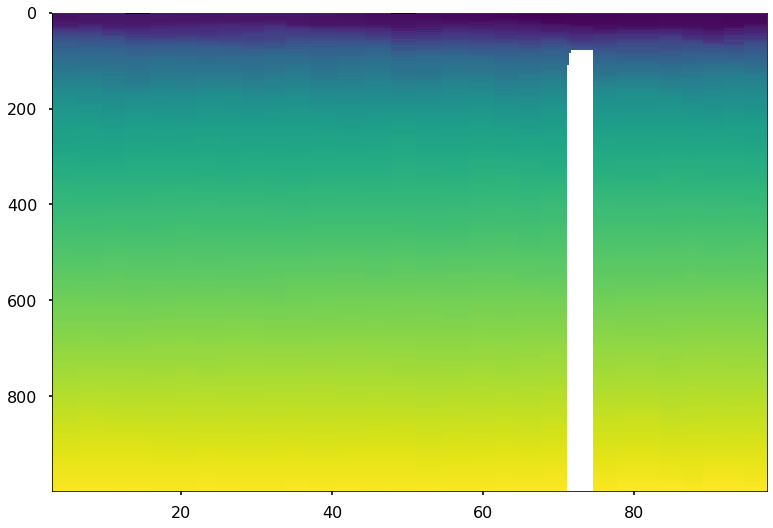

In [235]:
plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)
plt.gca().invert_yaxis()

# So, because there that weird spot over dog knoll here, I am going to slice that out for all of the variables I am working with to make sure the derivatives don't get wonky

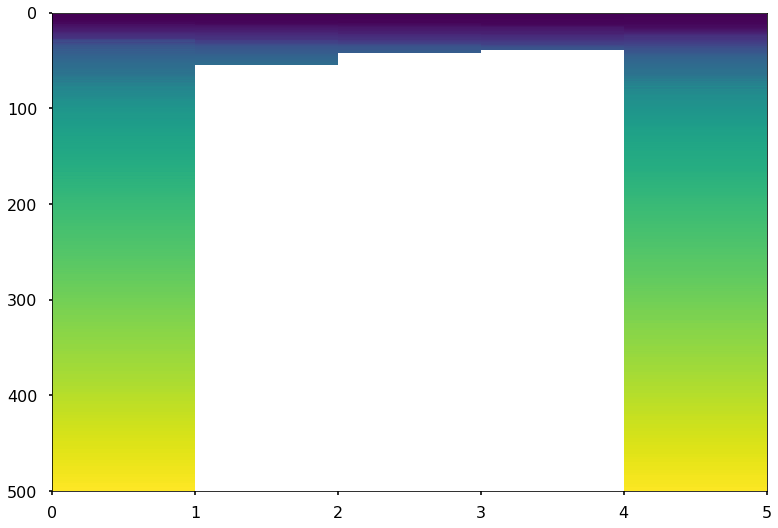

In [236]:
plt.pcolormesh(geogriddensity[:,21:26])
plt.gca().invert_yaxis()

In [237]:
segment_distances.shape

(34,)

In [238]:
# geogriddensity = np.delete(geogriddensity, [22,23,24,25], axis=1)
# segment_distances = np.delete(segment_distances,[22,23,24,25])
# subset_DAC_ds = np.delete(subset_DAC_ds,[22,23,24,25])

geogriddensity[:,22:27] = np.nan
#segment_distances[22:26] = np.nan
#subset_DAC_ds[22:26] = np.nan

In [239]:
subset_DAC_ds

array([-0.03903802, -0.05422466, -0.03836621, -0.04721522, -0.06423906,
       -0.05160467, -0.04843251, -0.06978201, -0.07305254, -0.06051059,
       -0.07028914, -0.07176072, -0.03979869, -0.01292571, -0.02869096,
       -0.04988865, -0.04766699, -0.03117665, -0.03369654, -0.039971  ,
       -0.04354766, -0.04582973, -0.05056162, -0.04093393, -0.02096769,
       -0.02705   , -0.07075979, -0.05907164, -0.07109651, -0.06264311,
       -0.0638385 , -0.08079393, -0.08042199, -0.06554232])

In [240]:
segment_distances

array([2951.9056699 , 3351.81222364, 3257.9227668 , 3023.45414612,
       3281.5696902 , 3279.11162071, 3036.31921149, 2879.85729935,
       3072.08738531, 2844.43288424, 2912.26885073, 3195.66482331,
       3688.51637894, 3547.76803145, 3555.01504334, 3224.16860251,
       3463.89949066, 3526.00569282, 3350.46943998, 3149.53305697,
       3083.04093878, 3082.67055404,  346.38421985,  284.04442092,
        273.75343003, 2910.7168344 , 3119.7892904 ,   67.97177654,
       5577.48103783, 2966.69259153, 2882.04247735, 2691.5506148 ,
       2710.45557104, 2970.42007801])

/tmp/ipykernel_83379/1606328036.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)


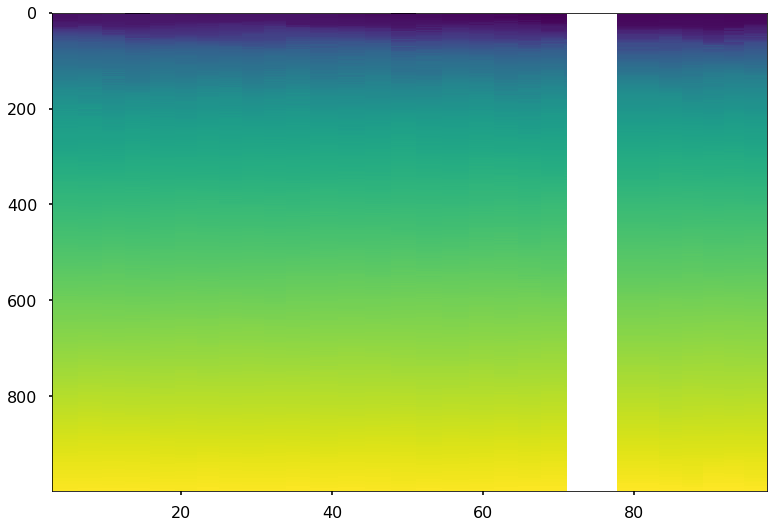

In [241]:
plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)
plt.gca().invert_yaxis()

In [242]:
d_rho_dy = np.gradient(geogriddensity,axis=1)/segment_distances

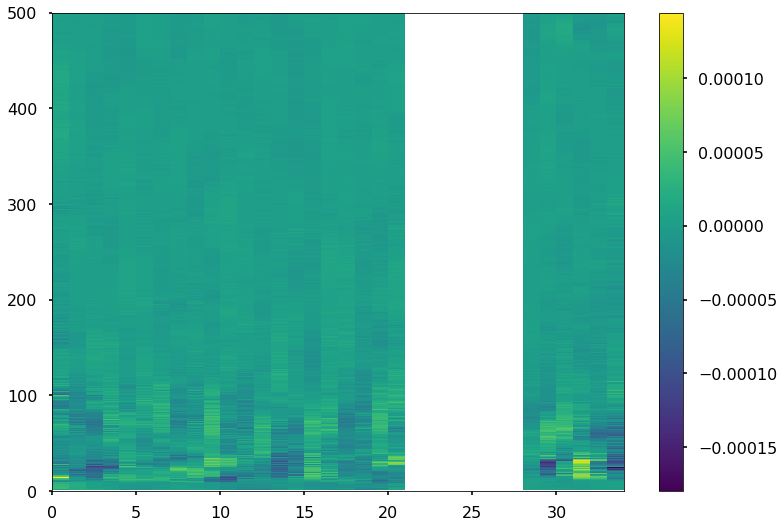

In [243]:
plt.pcolormesh(d_rho_dy)
plt.colorbar()

## Drop the one bad segment

In [244]:
# geogriddensity = np.delete(geogriddensity, [23], axis=1)
# segment_distances = np.delete(segment_distances,[23])
# subset_DAC_ds = np.delete(subset_DAC_ds,[23])
# d_rho_dy = np.delete(d_rho_dy,[23],axis=1)

# geogriddensity[:,23] = np.nan
# d_rho_dy[:,23] = np.nan


# get $\frac{\partial u}{\partial z}$

ok, now we have all the components of the right hand side to give us how the velocity changes with depth :

$$
\frac{g}{\rho f}\frac{\partial \rho}{\partial y}
$$

In [245]:
import seawater as sw

CF = sw.extras.f(ds.start_lat.mean())

g = sw.eos80.g(ds.start_lat.mean(), 0)

therm_wind = (1/CF)*(g/1027)*d_rho_dy


# Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $v$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

In [246]:
from scipy import integrate

# replace nan with zeros for integration
nanind = np.where(np.isnan(therm_wind) == True)
therm_wind[np.where(np.isnan(therm_wind) == True)] = 0

# flip to integrate from bottom, then flip back
rel_Vg = integrate.cumtrapz(therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]
#rel_Vg[nanind] = np.nan

In [247]:
np.arange(0,rel_Vg.shape[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

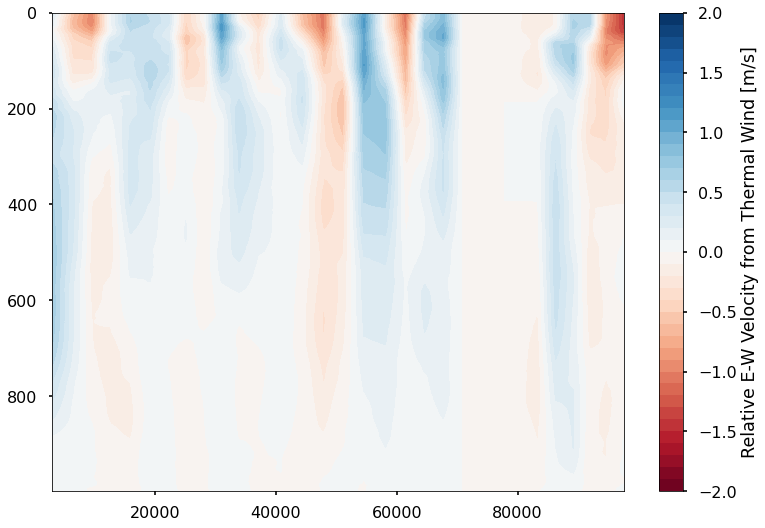

In [248]:
plt.contourf(np.cumsum(segment_distances),geo_griddepth,rel_Vg,cmap='RdBu',levels=np.arange(-2,2.01,0.1))
#plt.contourf(np.arange(0,rel_Vg.shape[1]),geo_griddepth,rel_Vg,cmap='RdBu',levels=np.arange(-2,2.01,0.1))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

# add the reference velocity

$$
V_{abs}(x,z) = V_{rel}(x,z) + V_{ref}(x)
$$

The reference, $V_{ref}$, is calculated from the DAC ($V_{dac}$) such that:

$$
V_{ref}(x) = V_{dac} - \frac{1}{h}\int_h V_{g}(x,z)dz
$$

Text(0.5, 0, 'Along Track Distance [km]')

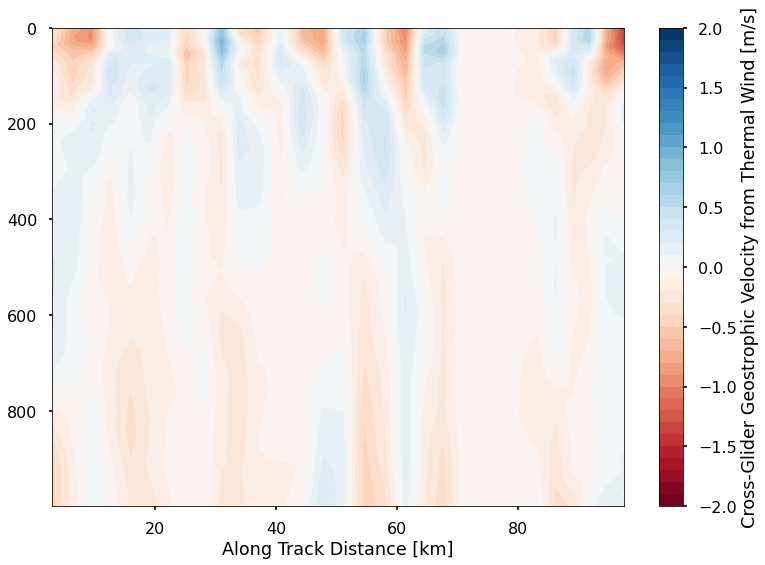

In [249]:
vref = subset_DAC_ds - np.nanmean(rel_Vg,axis=0)

Vgeo = rel_Vg + vref

plt.contourf(np.cumsum(segment_distances)/1000,geo_griddepth,Vgeo,cmap='RdBu',levels=np.arange(-2,2.01,0.1))
plt.colorbar(label='Cross-Glider Geostrophic Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()
plt.xlabel('Along Track Distance [km]')

## Put density on a finer grid than the ADCP data at first so now interpolate geostrophic velocity onto ADCP grid

In [250]:
Vgeo_interp = interp.griddata(geo_griddepth,Vgeo,griddepth, method='linear')
Vgeo_interp.shape

(102, 34)

## Now let's smooth the geostrophic velocity

### Experimenting on window size

In [251]:
window_size = 11

test = np.empty(len(segment_distances_a)-window_size)
test[:] = np.nan

for x in np.arange(0,len(segment_distances_a)-window_size):
    test[x] = np.sum(segment_distances_a[x:x+window_size])

np.mean(test)  

29854.84508565278

### So a window size of 11 is approximately a 30 km window (Todd et al. 2017)

In [256]:
from scipy.signal import savgol_filter

window_size = 11

smoothed_Vgeo = savgol_filter(Vgeo, window_size, 3,axis=1) # window size 11, polynomial order 3, should be axis 1
smoothed_Vgeo_interp = savgol_filter(Vgeo_interp, window_size, 3,axis=1) # window size 11, polynomial order 3, should be axis 1

mean_smoothed_Vgeo_interp = np.nanmean(smoothed_Vgeo_interp,axis=1)
std_smoothed_Vgeo_iterp = np.nanstd(smoothed_Vgeo_interp,axis=1)

mean_Vgeo_interp = np.nanmean(Vgeo_interp,axis=1)
std_Vgeo_iterp = np.nanstd(Vgeo_interp,axis=1)


/tmp/ipykernel_83379/3254537843.py:8: RuntimeWarning: Mean of empty slice
  mean_smoothed_Vgeo_interp = np.nanmean(smoothed_Vgeo_interp,axis=1)
/tmp/ipykernel_83379/3254537843.py:11: RuntimeWarning: Mean of empty slice
  mean_Vgeo_interp = np.nanmean(Vgeo_interp,axis=1)


Text(0.5, 0, 'Along Track Distance [km]')

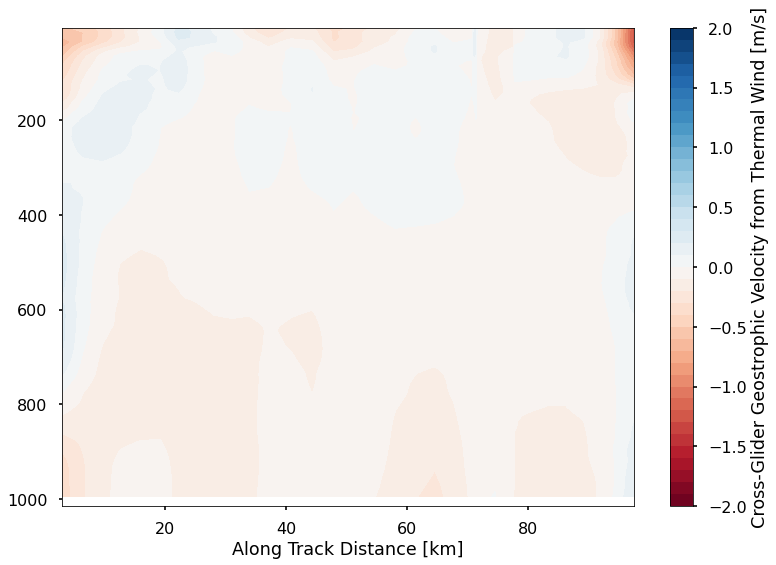

In [253]:

plt.contourf(np.cumsum(segment_distances)/1000,griddepth,smoothed_Vgeo_interp,cmap='RdBu',levels=np.arange(-2,2.01,0.1))
plt.colorbar(label='Cross-Glider Geostrophic Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()
plt.xlabel('Along Track Distance [km]')

## Now save a gridded dataset with all velocities!!!!

In [258]:
smoothed_Vgeo.shape

(500, 34)

In [262]:
len(geo_griddepth)

500

In [263]:
geo_grid_ds = xr.Dataset(
    data_vars=dict(
        vgeo = (["depth","dist"], smoothed_Vgeo),
        temp = (["depth", "dist"], geogridtemp),
        sal = (["depth", "dist"], geogridsal),
        density = (["depth", "dist"], geogriddensity)
    ),
    coords=dict(
        depth=geo_griddepth,
        dist=segment_distances
    ),
    attrs=dict(description="Processed RU29 AD2CP velocity, geostrophic velocity, and CTD data from the 2021 Deployment #2. Gridded/interpolated onto transect latitude grid"),
)

geo_grid_ds


<xarray.Dataset>
Dimensions:  (depth: 500, dist: 34)
Coordinates:
  * depth    (depth) int64 0 2 4 6 8 10 12 14 ... 986 988 990 992 994 996 998
  * dist     (dist) float64 2.952e+03 3.352e+03 3.258e+03 ... 2.71e+03 2.97e+03
Data variables:
    vgeo     (depth, dist) float64 -0.4893 -0.4566 -0.3643 ... 0.01999 0.1989
    temp     (depth, dist) float64 nan nan nan 29.37 ... 5.018 4.991 5.145 5.111
    sal      (depth, dist) float64 nan nan nan 34.88 ... 34.95 34.95 34.94 34.94
    density  (depth, dist) float64 nan nan nan ... 1.032e+03 1.032e+03 1.032e+03
Attributes:
    description:  Processed RU29 AD2CP velocity, geostrophic velocity, and CT...

In [264]:
fname = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Gridded/RU29_2021_Mission_2_Gridded_Geo_CTD.nc"
geo_grid_ds.to_netcdf(fname)


Text(0, 0.5, 'Depth [meters]')

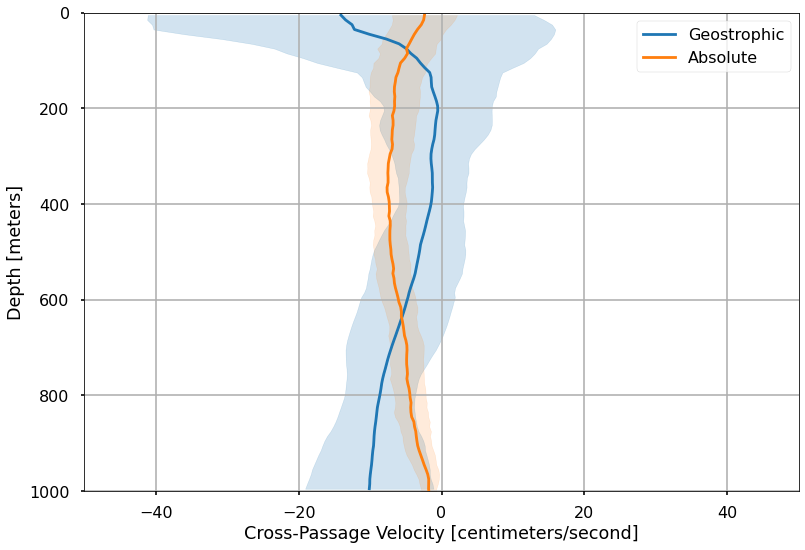

In [187]:
plt.plot(100*mean_smoothed_Vgeo_interp,griddepth,color='tab:blue',label='Geostrophic')
plt.fill_betweenx(griddepth,100*mean_smoothed_Vgeo_interp,100*(mean_smoothed_Vgeo_interp-std_smoothed_Vgeo_iterp),color='tab:blue',alpha=0.2)
plt.fill_betweenx(griddepth,100*mean_smoothed_Vgeo_interp,100*(mean_smoothed_Vgeo_interp+std_smoothed_Vgeo_iterp),color='tab:blue',alpha=0.2)

mean_cross_vel_2021_b = np.nanmean(cross_vel_b,axis=1)
std_cross_vel_2021_b  = np.nanstd(cross_vel_b,axis=1)
plt.plot(100*mean_cross_vel_2021_b, griddepth, color='tab:orange',label='Absolute')
plt.fill_betweenx(griddepth,100*mean_cross_vel_2021_b,100*(mean_cross_vel_2021_b-std_cross_vel_2021_b),color='tab:orange',alpha=0.15)
plt.fill_betweenx(griddepth,100*mean_cross_vel_2021_b,100*(mean_cross_vel_2021_b+std_cross_vel_2021_b),color='tab:orange',alpha=0.15)

plt.legend()
plt.xlim(-50,50)
plt.ylim(1000,0)
plt.grid()
plt.xlabel('Cross-Passage Velocity [centimeters/second]')
plt.ylabel('Depth [meters]')



## Calculate transport!

In [188]:
np.nansum(smoothed_Vgeo_interp*dz*segment_distances)/(10**6)

-5.085900146343287

## Save output for plotting elsewhere

In [59]:
smoothed_Vgeo_df = pd.DataFrame(np.column_stack([griddepth, mean_smoothed_Vgeo_interp, std_smoothed_Vgeo_iterp, mean_cross_vel_2021_b, std_cross_vel_2021_b]), columns=['depth','Vgeo_mean','Vgeo_std','Vabs_mean','Vabs_std'])
smoothed_Vgeo_df.to_csv('/home/jg1200/Data/GliderData/RU29/mean_std_Vgeo_Vabs_depth_profile_sep_2021.csv')
smoothed_Vgeo_df



,depth,Vgeo_mean,Vgeo_std,Vabs_mean,Vabs_std
0,5.0,-0.190653,0.262736,-0.023888,0.045506
1,15.0,-0.185025,0.271177,-0.025018,0.043260
2,25.0,-0.173547,0.272587,-0.028348,0.041263
3,35.0,-0.165130,0.274992,-0.033663,0.039816
4,45.0,-0.140241,0.250428,-0.038071,0.039573
...,...,...,...,...,...
97,975.0,-0.093407,0.081006,-0.017930,0.014155
98,985.0,-0.093691,0.083328,-0.018004,0.012780
99,995.0,-0.094354,0.085253,-0.018153,0.010733
100,1005.0,NaN,NaN,-0.017398,0.010401
